# 1: Git Checkout - new branch

In [92]:
!git config --global user.email "ved.30dec@gmail.com"
!git config --global user.name "vedpd"


In [2]:
!git clone https://github.com/vedpd/USD-MS-AAI.git
%cd USD-MS-AAI


d:\Masters\M2_AAI-501 Introduction to Artificial Intelligence\Group Project\Symptom2Disease\USD-MS-AAI


Cloning into 'USD-MS-AAI'...


In [3]:
!git checkout -b module2-ved


Switched to a new branch 'module2-ved'


# 2 : Project : Multi class symptom classifier

## 2.1 : Load the libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import pickle
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manuk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2.2 : Load the dataset

In [67]:
## Step 2: Load and Prepare Data
symptom_df = pd.read_csv("D:\Masters\M2_AAI-501 Introduction to Artificial Intelligence\Group Project\Symptom2Disease\Symptom2Disease.csv")


In [51]:
symptom_df.head()

Unnamed: 0      label                                               text
0           0  Psoriasis  I have been experiencing a skin rash on my arm...
1           1  Psoriasis  My skin has been peeling, especially on my kne...
2           2  Psoriasis  I have been experiencing joint pain in my fing...
3           3  Psoriasis  There is a silver like dusting on my skin, esp...
4           4  Psoriasis  My nails have small dents or pits in them, and...

In [68]:
symptom_df = symptom_df.drop(columns=["Unnamed: 0"])
symptom_df.columns = ["label", "text"]
symptom_df.head()

label                                               text
0  Psoriasis  I have been experiencing a skin rash on my arm...
1  Psoriasis  My skin has been peeling, especially on my kne...
2  Psoriasis  I have been experiencing joint pain in my fing...
3  Psoriasis  There is a silver like dusting on my skin, esp...
4  Psoriasis  My nails have small dents or pits in them, and...

In [69]:
# Encode labels
label_encoder = LabelEncoder()
symptom_df["encoded_label"] = label_encoder.fit_transform(symptom_df["label"])


In [70]:
symptom_df.head()

label                                               text  encoded_label
0  Psoriasis  I have been experiencing a skin rash on my arm...             15
1  Psoriasis  My skin has been peeling, especially on my kne...             15
2  Psoriasis  I have been experiencing joint pain in my fing...             15
3  Psoriasis  There is a silver like dusting on my skin, esp...             15
4  Psoriasis  My nails have small dents or pits in them, and...             15

##2.3 : Exploratory Data Analysis

In [71]:
def save_and_show_plot(fig, path):
    fig.tight_layout()
    fig.savefig(path)
    plt.show()


### Let's create a folder to save all the EDA

In [72]:
import os

# Define base path to your working branch directory
base_path = "D:\Masters\M2_AAI-501 Introduction to Artificial Intelligence\Group Project\Symptom2Disease"

# Create visualization folders
os.makedirs(os.path.join(base_path, "Visualizations/WordClouds/PerLabel"), exist_ok=True)

# Optional: Create README file
readme_path = os.path.join(base_path, "Visualizations", "README.md")
with open(readme_path, "w") as f:
    f.write("This folder contains visualizations from symptom-level data, including word clouds.\n")

print("Folder structure created successfully.")


Folder structure created successfully.


### Class Distribution

In [73]:
symptom_df['label'].unique()

array(['Psoriasis', 'Varicose Veins', 'Typhoid', 'Chicken pox',
       'Impetigo', 'Dengue', 'Fungal infection', 'Common Cold',
       'Pneumonia', 'Dimorphic Hemorrhoids', 'Arthritis', 'Acne',
       'Bronchial Asthma', 'Hypertension', 'Migraine',
       'Cervical spondylosis', 'Jaundice', 'Malaria',
       'urinary tract infection', 'allergy',
       'gastroesophageal reflux disease', 'drug reaction',
       'peptic ulcer disease', 'diabetes'], dtype=object)

In [74]:
symptom_df['label'].nunique()

24

In [75]:
print("shape of the dataset", symptom_df.shape)
print(symptom_df['label'].value_counts())

shape of the dataset (1200, 3)
label
Psoriasis                          50
Varicose Veins                     50
Typhoid                            50
Chicken pox                        50
Impetigo                           50
Dengue                             50
Fungal infection                   50
Common Cold                        50
Pneumonia                          50
Dimorphic Hemorrhoids              50
Arthritis                          50
Acne                               50
Bronchial Asthma                   50
Hypertension                       50
Migraine                           50
Cervical spondylosis               50
Jaundice                           50
Malaria                            50
urinary tract infection            50
allergy                            50
gastroesophageal reflux disease    50
drug reaction                      50
peptic ulcer disease               50
diabetes                           50
Name: count, dtype: int64


label
Psoriasis                          50
Varicose Veins                     50
Typhoid                            50
Chicken pox                        50
Impetigo                           50
Dengue                             50
Fungal infection                   50
Common Cold                        50
Pneumonia                          50
Dimorphic Hemorrhoids              50
Arthritis                          50
Acne                               50
Bronchial Asthma                   50
Hypertension                       50
Migraine                           50
Cervical spondylosis               50
Jaundice                           50
Malaria                            50
urinary tract infection            50
allergy                            50
gastroesophageal reflux disease    50
drug reaction                      50
peptic ulcer disease               50
diabetes                           50
Name: count, dtype: int64


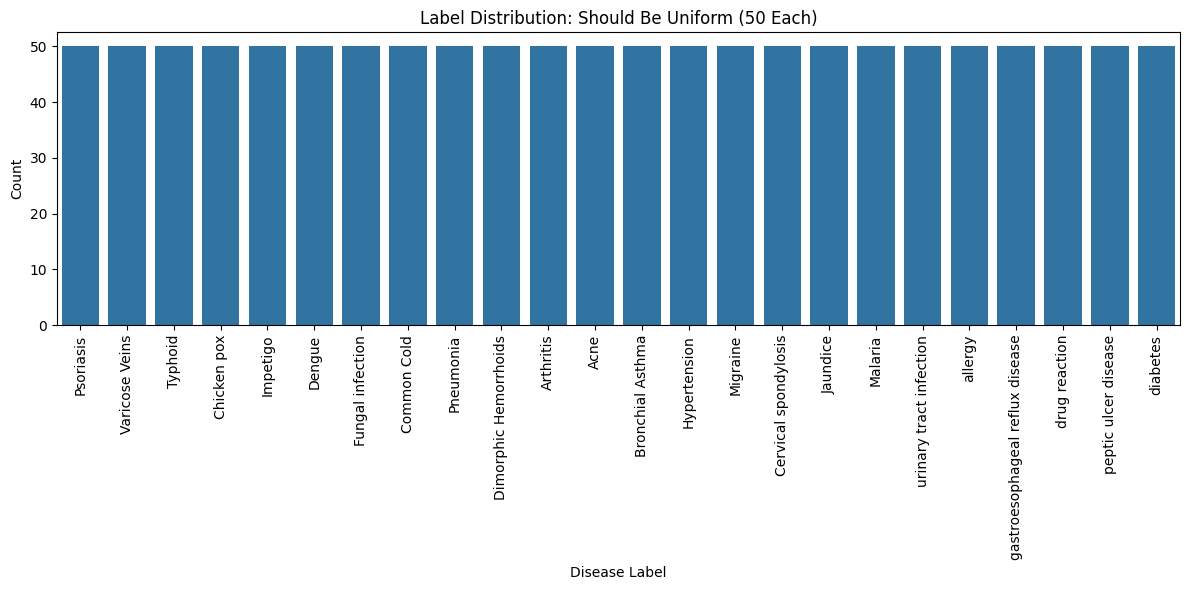

In [76]:
# Confirm class balance
label_counts = symptom_df['label'].value_counts()
print(label_counts)

# Plotting for visual confirmation
plt.figure(figsize=(12,6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.title("Label Distribution: Should Be Uniform (50 Each)")
plt.ylabel("Count")
plt.xlabel("Disease Label")
plt.tight_layout()
plt.show()


### Word Cloud of all symptoms

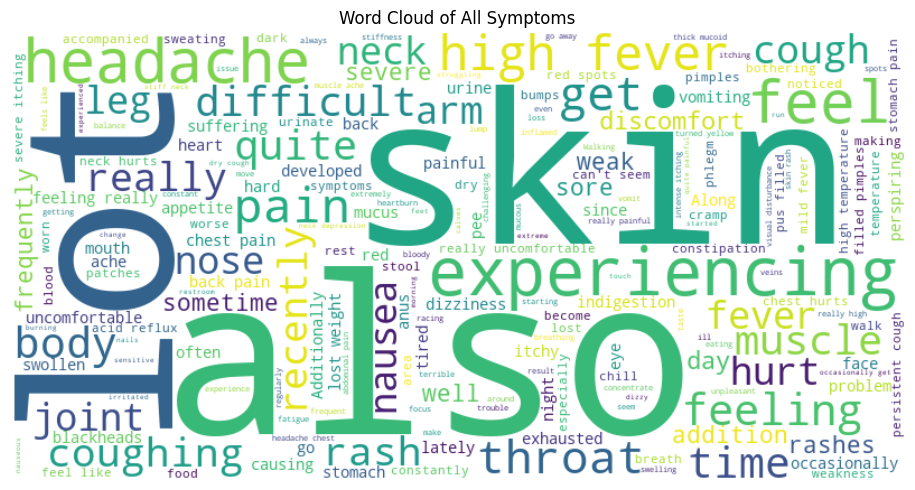

In [77]:
# Create folders if they don't exist
import os
combined_wc_path = os.path.join(base_path, "Visualizations/WordClouds/Combined.png")

all_text = ' '.join(symptom_df['text'].values)
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Symptoms")
plt.tight_layout()
plt.savefig(combined_wc_path)
plt.show()

**Interpretation of Combined Word Cloud (All Symptoms)**

The word cloud gives a visual representation of the **most frequently occurring words across all symptom descriptions** in the dataset. The size of each word reflects how often it appears — **larger words are more common**.

---

**Top Frequent Terms**

- **"skin", "also", "pain", "experiencing", "headache", "fever", "feel"** — These are the most prominent, suggesting:

  - **"skin"** might be a common context or location for multiple symptoms (e.g., rashes, itching).
  - **"pain"** is a general symptom occurring across many disease types.
  - **"fever"** and **"headache"** are classic general indicators of illness, commonly reported across diverse conditions.
  - **"also"**, **"experiencing"**, **"feel"**, and **"get"** reflect how patients describe their symptoms (contextual narrative language).

---

**Semantic Clues**

- There’s a mix of **anatomical terms** (e.g., _throat, chest, arm, neck, back, joint_) and **symptom descriptors** (e.g., _itchy, sore, painful, dizzy, exhausted_), showing that people mention both **where** and **what** they are experiencing.

---

**Common Symptoms**

Words like:

- **"rash", "coughing", "nausea", "throat", "muscle", "dizziness", "fatigue", "sore", "joint"**  
  indicate that these symptoms recur across different classes (conditions).

---

**Subjective Expressions**

Words such as:

- **"quite", "really", "frequently", "recently", "difficult", "occasionally"**  
  reflect **subjective frequency or intensity**, which could provide signals for condition severity or temporal trends.

---

**What This Tells us**

- **Rich Vocabulary**: The dataset contains natural-language symptom descriptions, not just clinical keywords — great for training NLP models.
- **Overlap Across Classes**: Frequent use of common symptom words may indicate **semantic overlap between classes**, which could make classification harder.
- **Potential Need for Contextual Models**: Since terms like _pain_ and _fever_ are nonspecific, it highlights the need for models that understand **contextual cues** (e.g., LSTM, GRU, BERT).


### Word Cloud individual Symptoms

In [46]:
base_path

'D:\\Masters\\M2_AAI-501 Introduction to Artificial Intelligence\\Group Project\\Symptom2Disease'

In [47]:
base_path

'D:\\Masters\\M2_AAI-501 Introduction to Artificial Intelligence\\Group Project\\Symptom2Disease'

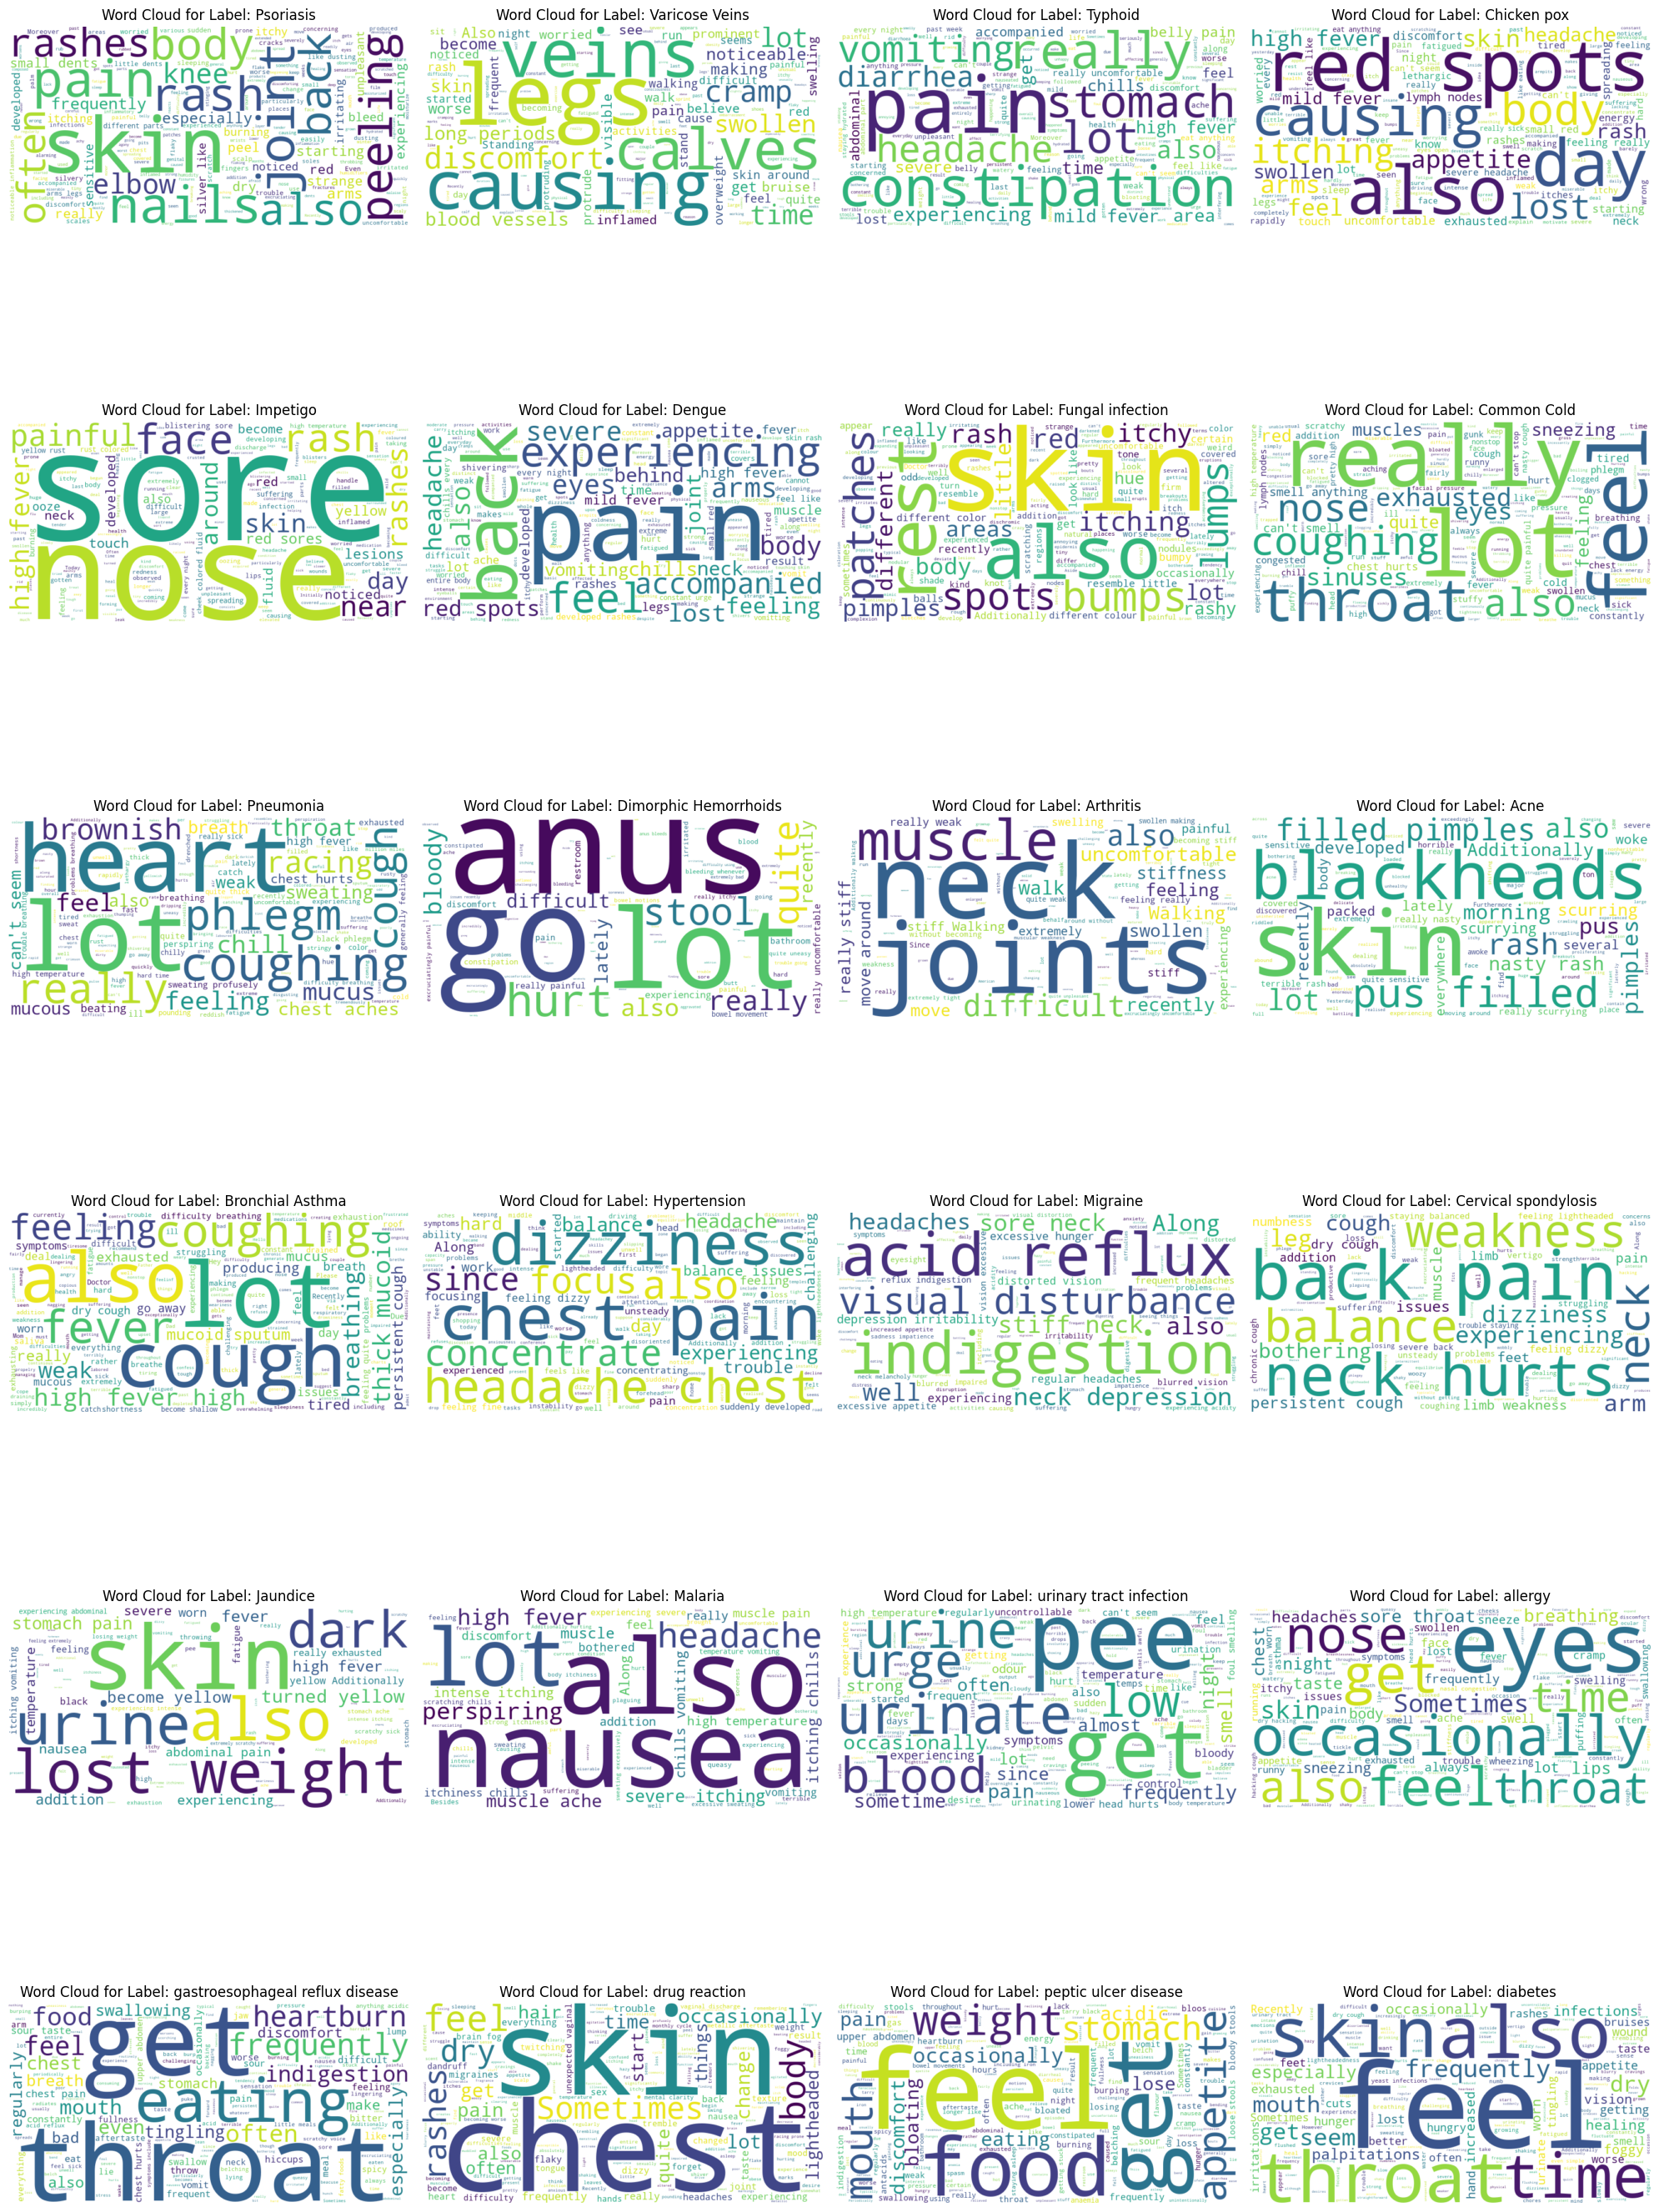

In [78]:
per_label_path = os.path.join(base_path,"Visualizations","WordClouds","PerLabel")


# Word clouds per label
from math import ceil
unique_labels = symptom_df['label'].unique()
num_labels = len(unique_labels)
cols = 4
rows = ceil(num_labels / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    subset = symptom_df[symptom_df['label'] == label]
    text = ' '.join(subset['text'].values)
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Word Cloud for Label: {label}")

    # Save word cloud to the correct path
    label_filename = f"{label}.png"
    wc.to_file(os.path.join(per_label_path, label_filename))

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Word Count Analysis

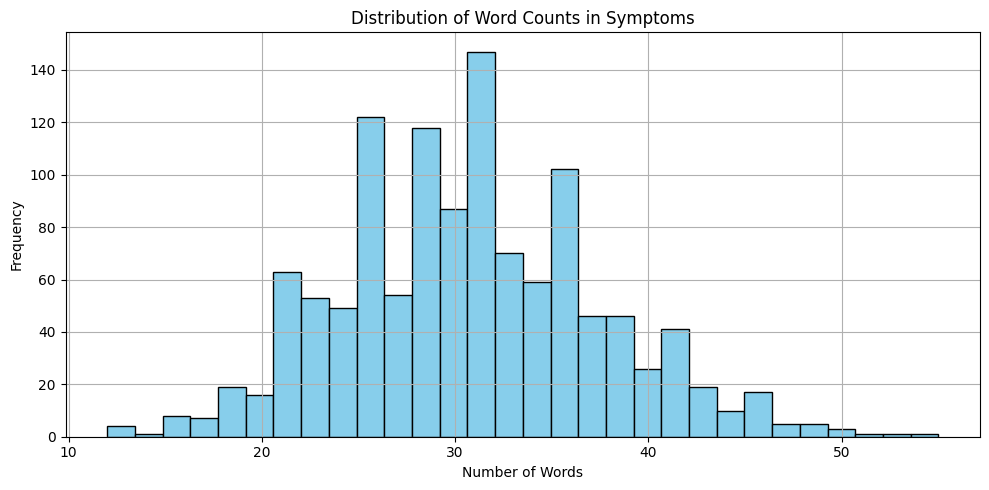

In [79]:
# Word Count Analysis
symptom_df['word_count'] = symptom_df['text'].apply(lambda x: len(x.split()))
fig = plt.figure(figsize=(10, 5))
plt.hist(symptom_df['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Symptoms')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)

# Save to WordCount_analysis.png in correct path
wc_analysis_path = os.path.join(base_path, "Visualizations", "WordCount_analysis.png")
# os.makedirs(os.path.dirname(wc_analysis_path), exist_ok=True)
save_and_show_plot(fig, wc_analysis_path)


**Analysis of Word Count Distribution in Symptom Texts**

1. Modal Word Count (Most Frequent Bin):

 - The highest frequency is for symptom descriptions containing around 30–32 words.

 - This suggests that most entries are moderately descriptive but not overly long.

2. Overall Distribution Shape:

 - The distribution is slightly right-skewed, meaning there are fewer extremely long descriptions.

 - There’s a bell-like central peak with gradual tapering on both sides, though the right tail is longer.

3. Range and Spread:

 - Word counts vary from under 15 to over 50.

 - The majority of symptoms seem to fall in the 20–40 word range, which aligns well with typical short-form clinical documentation.

4. Outliers:

 - A few entries exceed 50 words, which may indicate overly verbose or compound symptom entries. These could potentially be cleaned or split in preprocessing if needed.

5. Implications for Modeling:

 - The relatively narrow range and lack of extremely short entries suggest less need for aggressive padding or truncation if using models like RNNs or Transformers.

 - For BERT-style models with a max token limit of 512, these descriptions are well within capacity.

**Actionable Steps:**
 - Consider normalizing descriptions over 50 words, possibly through summarization or truncation for consistency.

 - Short descriptions (<15 words) could be flagged for manual inspection or enrichment if clinical completeness is a concern.

 - The word count feature itself may be useful as a predictor or input feature in metadata-augmented models.

## 2.4 : Modelling :

### Why Use LSTM or GRU for Symptom Classification?

Symptom descriptions are textual data, often short phrases or sentences that carry important sequential information. Traditional machine learning models like Naive Bayes or Logistic Regression treat text as a bag of words, ignoring the order in which symptoms are mentioned. However, in medical contexts, the **sequence and co-occurrence** of terms can be crucial for understanding meaning.

This is where **Recurrent Neural Networks (RNNs)** — especially **LSTM** and **GRU** — become valuable.

---

#### LSTM/GRU – Sequence-Aware Models
- LSTM and GRU are specialized neural networks that process data **sequentially**, preserving the order of words and capturing **contextual dependencies**.
- They are designed to overcome the **vanishing gradient problem** that traditional RNNs face, enabling them to retain information across longer sequences.
- In symptom classification, these models can **learn patterns like "sudden chest pain" vs. "chronic pain"**, which might lead to different diagnoses even if the word "pain" is common.

---

#### Why Not Just Use a Dense Neural Net?
Dense (fully connected) layers do not capture word order. A sentence like *"no fever but chills"* might be misclassified if the model treats it like *"chills but no fever"*. LSTM/GRU helps prevent this by modeling **temporal dependencies**.

---

#### Summary
- **Use LSTM/GRU**: If you want a model that understands the **sequence and structure** of symptom descriptions.
- **Better generalization**: Especially important for rare or nuanced symptom combinations.
- **Improved performance**: When compared to non-sequential models on text classification tasks.

In the next section, we'll build and train an LSTM-based deep learning model for multi-class symptom classification.


### Tokenization and padding

**Tokenization and Padding in NLP**

Before feeding text data into a deep learning model like LSTM or GRU, we must convert the raw text into a numerical format. Two essential steps in this process are **Tokenization** and **Padding**.

---

**What is Tokenization?**
- Tokenization is the process of converting a sentence into individual tokens (usually words), and then mapping those tokens to numerical values.

- For example, the sentence "I feel dizzy and nauseous" might become `[12, 87, 340, 5, 908]`.
- We use `Tokenizer` from Keras to do this. It builds a vocabulary from the corpus and replaces each word with its corresponding index.

---

**Why Do We Tokenize?**
- Neural networks work with numbers, not text.
- Tokenization standardizes input and facilitates the learning of patterns within the data.
- Special tokens like `<OOV>` (Out-Of-Vocabulary) are used to handle unseen words during inference.

---

**What is Padding?**
- Different symptom descriptions have different lengths. But deep learning models need uniform input shapes.
- Padding ensures that all sequences are the same length by adding zeroes (or other values) to shorter sequences.
- For example: `[12, 87, 340]` → `[12, 87, 340, 0, 0, 0]` (if maxlen = 6)

---

**Resources to Learn More**
- [Keras Tokenizer Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)
- [Padding Sequences - TensorFlow Guide](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)
- [CS224N - Stanford NLP Course](https://web.stanford.edu/class/cs224n/)
- [The Illustrated Word2Vec](https://jalammar.github.io/illustrated-word2vec/)

---

In [ ]:
# Tokenizer settings
vocab_size = 10000
max_seq_length = 100

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(symptom_df["text"])
sequences = tokenizer.texts_to_sequences(symptom_df["text"])

# Padding
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding="post")


In [ ]:
# ## Explanation: Tokenization turns text into numbers. Padding ensures all sequences are same length.
# tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
# tokenizer.fit_on_texts(symptom_df['text'])
# sequences = tokenizer.texts_to_sequences(symptom_df['text'])
# padded_sequences = pad_sequences(sequences, padding='post', maxlen=30)


### Step 4: Train-Test Split
We’ll split the padded data into training and validation sets. Since this is a multi-class classification problem, we’ll ensure the split is stratified — meaning each label is proportionally represented in both train and test sets.

**Ensuring Label Encoding is Used Properly**

- We previously created an `encoded_label` column using `LabelEncoder`. </br>
- Before performing the train-test split, we extract this encoded label column and ensure it's in the correct format (NumPy array) for stratification.
- This helps maintain class distribution across training and validation sets.


In [ ]:
labels_encoded = symptom_df["encoded_label"].values


In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(
#     padded_sequences,
#     symptom_df["encoded_label"].values,
#     test_size=0.2,
#     stratify=symptom_df["encoded_label"].values,
#     random_state=42
# )

X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels_encoded,
    test_size=0.2,
    stratify=labels_encoded,
    random_state=42
)


In [ ]:
X_train.shape, X_val.shape

((960, 100), (240, 100))

### Why Use LSTM for Text Classification?

In natural language processing (NLP), the meaning of a sentence depends not just on individual words but also on the order in which they appear. Traditional models like Logistic Regression or Decision Trees fail to capture these sequential patterns.

That's where **Recurrent Neural Networks (RNNs)** and their variants like **LSTM (Long Short-Term Memory)** come in. LSTM is a special kind of RNN capable of learning long-term dependencies. It remembers context over time and is well-suited for tasks like sentiment analysis, symptom classification, and language modeling.

We’ll now build an LSTM-based deep learning model to classify symptoms based on textual descriptions.


### Building the LSTM Model

We’ll now build a neural network using the `Sequential` API in Keras:

- **Embedding Layer**: Converts each word into a dense vector of fixed size (`embedding_dim`). This allows the model to understand semantic similarity between words.
- **LSTM Layer**: Processes the sequence of word embeddings and captures dependencies between words.
- **Dense + Dropout Layers**: Add non-linearity and help prevent overfitting.
- **Output Layer**: Uses `softmax` activation to output probabilities for each class.

We use `sparse_categorical_crossentropy` as the loss function since our labels are integers (not one-hot encoded).

In [ ]:
# embedding_dim = 128
# lstm_units = 64
# dropout_rate = 0.3
# num_classes = len(label_encoder.classes_)

# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
# model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(dropout_rate))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model parameters
embedding_dim = 100
lstm_units = 128
dropout_rate = 0.3
num_classes = len(label_encoder.classes_)

# Initialize the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Explicitly build the model to initialize parameters
model.build(input_shape=(None, max_seq_length))

# Display model architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,127,064 (4.30 MB)

 Trainable params: 1,127,064 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

**What is happening here?**
- `Embedding` layer turns word indexes into dense vectors.
- `LSTM` processes sequential input with memory of previous inputs.
- `Dense` layers perform final classification.
- `Dropout` helps prevent overfitting.
- `Softmax` gives a probability distribution over classes.

---

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.0474 - loss: 3.1801 - val_accuracy: 0.0417 - val_loss: 3.1787
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.0420 - loss: 3.1793 - val_accuracy: 0.0417 - val_loss: 3.1782
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.0479 - loss: 3.1776 - val_accuracy: 0.0417 - val_loss: 3.1786
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.0450 - loss: 3.1796 - val_accuracy: 0.0417 - val_loss: 3.1784
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.0315 - loss: 3.1799 - val_accuracy: 0.0417 - val_loss: 3.1782
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.0319 - loss: 3.1786 - val_accuracy: 0.0417 - val_loss: 3.1783
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.0415 - loss: 3.1781 - val_accuracy: 0.0417 - val_loss: 3.1782
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.0496 - loss: 3.1776 - val_accuracy: 0.

### Model Evaluation & Visualization

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0422 - loss: 3.1781

Test Accuracy: 0.0417


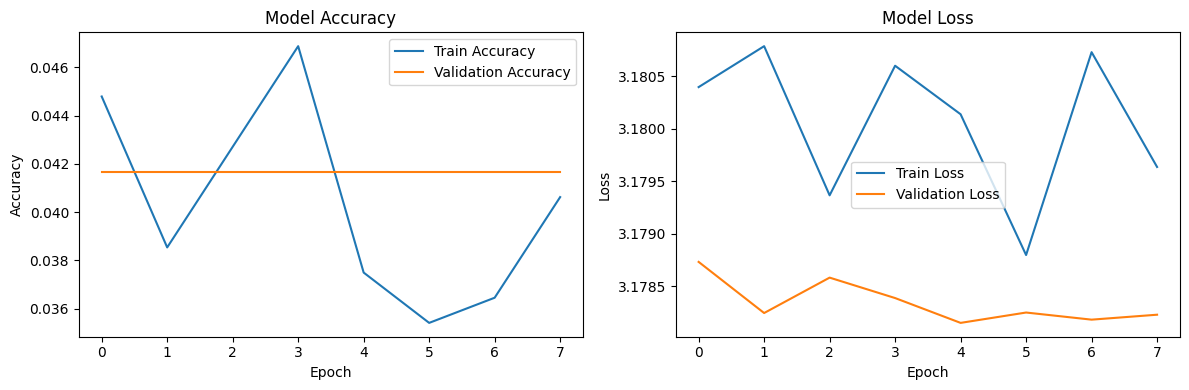

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


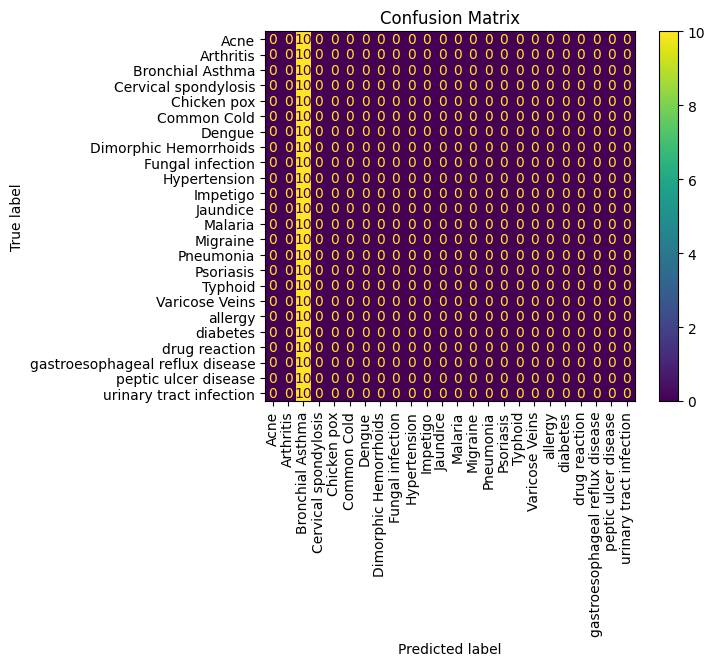


Classification Report:

                                 precision    recall  f1-score   support

                           Acne       0.00      0.00      0.00        10
                      Arthritis       0.00      0.00      0.00        10
               Bronchial Asthma       0.04      1.00      0.08        10
           Cervical spondylosis       0.00      0.00      0.00        10
                    Chicken pox       0.00      0.00      0.00        10
                    Common Cold       0.00      0.00      0.00        10
                         Dengue       0.00      0.00      0.00        10
          Dimorphic Hemorrhoids       0.00      0.00      0.00        10
               Fungal infection       0.00      0.00      0.00        10
                   Hypertension       0.00      0.00      0.00        10
                       Impetigo       0.00      0.00      0.00        10
                       Jaundice       0.00      0.00      0.00        10
                        M

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Predict and display confusion matrix
y_pred = model.predict(X_val)
y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_val, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred_labels, target_names=label_encoder.classes_))


In [ ]:
import os
os.getcwd()

from google.colab import drive
drive.mount('/content/drive')


# !ls '/content/drive/My Drive/USD-MS-AAI'


Mounted at /content/drive
ls: cannot access '/content/drive/My Drive/USD-MS-AAI': No such file or directory


In [ ]:
import os
nb_path = os.path.abspath("Multiclass_Symptom_Classifier_Using_LTSM_GRU.ipynb")
print("Your notebook is at:", nb_path)


Your notebook is at: /content/USD-MS-AAI/Multiclass_Symptom_Classifier_Using_LTSM_GRU.ipynb


In [ ]:
# from google.colab import drive
# import os
# import shutil
# import glob

# # Mount Google Drive
# drive.mount('/content/drive')

# # Find your repo folder under MyDrive
# possible_paths = glob.glob("/content/drive/MyDrive/*")
# for path in possible_paths:
#     print(path)


In [ ]:
import os
import shutil

# Define source and destination paths
src_path = "/content/drive/MyDrive/Colab Notebooks/Multiclass_Symptom_Classifier_Using_LTSM_GRU.ipynb"
dst_dir = "/content/drive/MyDrive/USD-MS-AAI/Module 2/Modelling"
dst_path = os.path.join(dst_dir, "Multiclass_Symptom_Classifier_Using_LTSM_GRU.ipynb")

# Create destination directory if it doesn't exist
os.makedirs(dst_dir, exist_ok=True)

# Move the notebook
if os.path.exists(src_path):
    shutil.move(src_path, dst_path)
    print(f"✅ Notebook moved to: {dst_path}")
else:
    print("❌ Source notebook not found.")


✅ Notebook moved to: /content/drive/MyDrive/USD-MS-AAI/Module 2/Modelling/Multiclass_Symptom_Classifier_Using_LTSM_GRU.ipynb


# MODELLING Approach-2

## 
The classical or traditional machine learning models are non-deep learning mdoels that are widely used for
text classification problems like symptoms classification.
The traditional models rely on well-established statistical and algorithm principles.
In Symptoms-->Disease problem, traditional models are very effective when paired with text vectorization mothods like TF-IDF or CountVectorizer.


### Logistic Regression

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [106]:
#Preprocessing
le=LabelEncoder()
symptom_df['label_encoded']=le.fit_transform(symptom_df['label'])

#Split training data
X_train, X_test, y_train, y_test = train_test_split(
    symptom_df['text'], symptom_df['label_encoded'], test_size=0.2, random_state=42, stratify=symptom_df['label_encoded'])

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)



In [107]:
# Evaluation
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))




Accuracy: 0.9375


Accurary with Linear regression model for Symptoms to Disease of 0.9375 is good startig metric.
But class-wise performance also should be examined using classification report.

In [108]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))



Classification Report:

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       0.91      1.00      0.95        10
               Bronchial Asthma       0.91      1.00      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.78      0.70      0.74        10
                    Common Cold       1.00      1.00      1.00        10
                         Dengue       0.80      0.80      0.80        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       0.91      1.00      0.95        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        10
                       Jaundice       1.00      1.00      1.00        10
                        M

The classification report evaluetes the performance of the model for each class of the label.
Precision: 


In [112]:
# Classification report for Train data

log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train_vec, y_train)
y_train_pred=log_reg.predict(X_train_vec)

print("\nClassification Report Train data:\n")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))



Classification Report Train data:

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        40
                      Arthritis       1.00      1.00      1.00        40
               Bronchial Asthma       1.00      1.00      1.00        40
           Cervical spondylosis       1.00      1.00      1.00        40
                    Chicken pox       1.00      1.00      1.00        40
                    Common Cold       1.00      1.00      1.00        40
                         Dengue       1.00      1.00      1.00        40
          Dimorphic Hemorrhoids       1.00      1.00      1.00        40
               Fungal infection       1.00      1.00      1.00        40
                   Hypertension       1.00      1.00      1.00        40
                       Impetigo       1.00      1.00      1.00        40
                       Jaundice       1.00      1.00      1.00        40
              

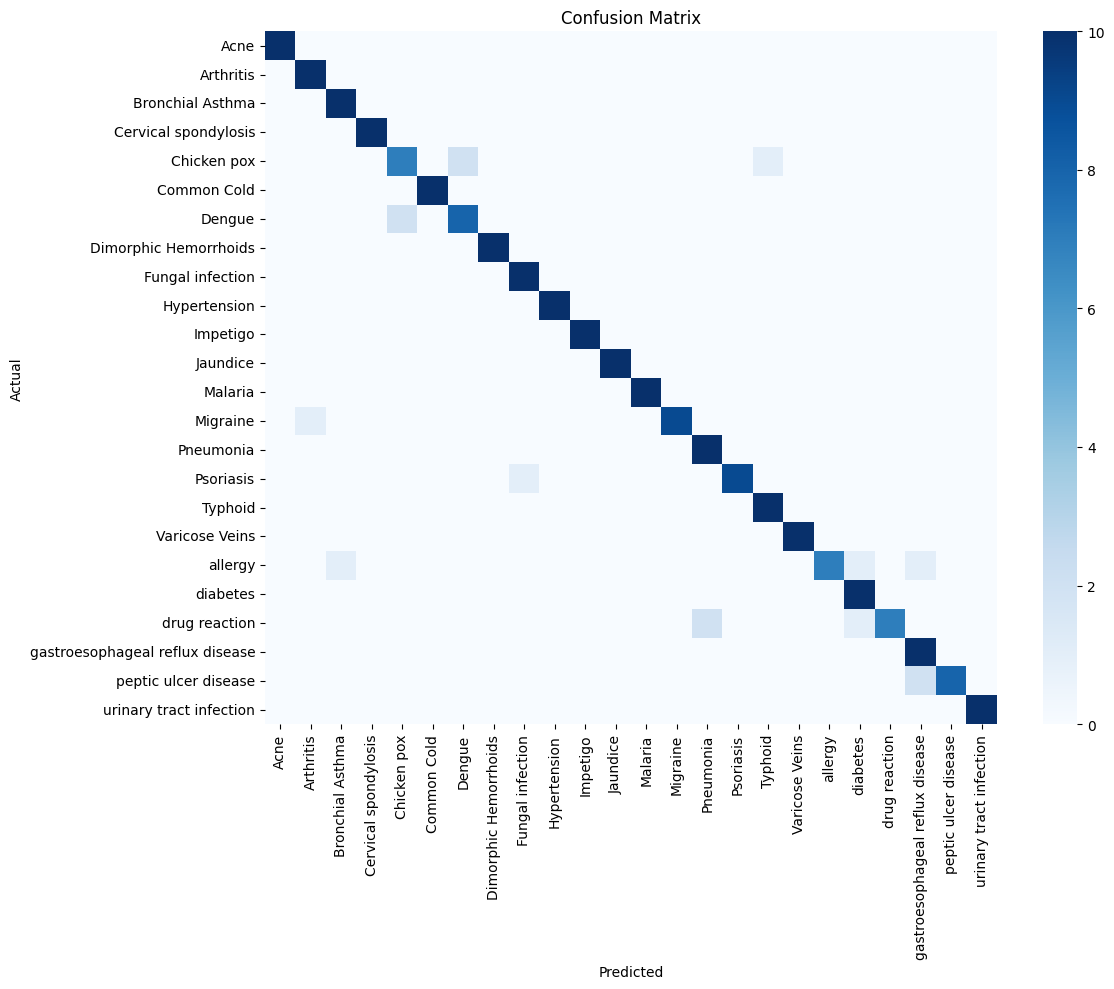

In [94]:

# Confusion matrix fTest data
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

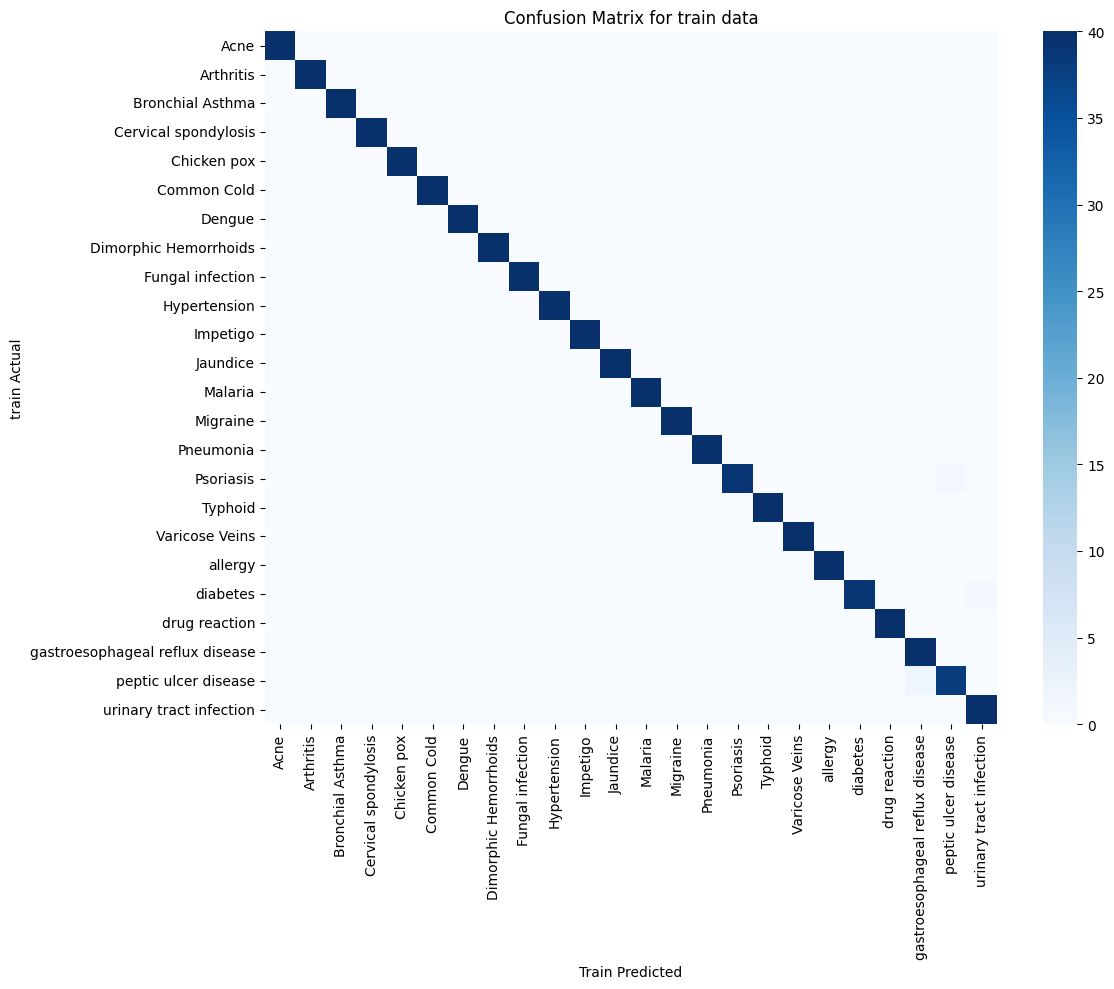

In [113]:
# Confusion matrix train data
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_train, annot=False, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for train data")
plt.xlabel("Train Predicted")
plt.ylabel("train Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()